# Домашнее задание к уроку 4: Сверточные сети

## Цель задания
Сравнить эффективность сверточных и полносвязных сетей на задачах компьютерного зрения, изучить преимущества CNN архитектур.

## Задание 1: Сравнение CNN и полносвязных сетей (40 баллов)

Создайте файл `homework_cnn_vs_fc_comparison.py`:

### 1.1 Сравнение на MNIST (20 баллов)
```python
# Сравните производительность на MNIST:
# - Полносвязная сеть (3-4 слоя)
# - Простая CNN (2-3 conv слоя)
# - CNN с Residual Block
# 
# Для каждого варианта:
# - Обучите модель с одинаковыми гиперпараметрами
# - Сравните точность на train и test множествах
# - Измерьте время обучения и инференса
# - Визуализируйте кривые обучения
# - Проанализируйте количество параметров
```

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
mnist_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=512, shuffle=False)

# CIFAR-10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar_train_loader = DataLoader(cifar_train, batch_size=128, shuffle=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=512, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 55.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.26MB/s]
100%|██████████| 170M/170M [00:02<00:00, 79.2MB/s] 


### Класс простой FCN

In [3]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.Dropout(0.25)
        )
    def forward(self, x):
        return self.net(x)


### Взял реализации классов сетей ниже с урока ( немного переписал покороче)

In [4]:

class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        out += self.shortcut(x)
        return self.relu(out)


In [6]:
class CNNResNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            ResidualBlock(32, 32),
            ResidualBlock(32, 64, stride=2),
            ResidualBlock(64, 64),

            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, num_classes),
        )

    def forward(self, x):
        return self.net(x)

### Функция для обучения и вычисления метрик

In [7]:
def train_and_evaluate(model, train_loader, test_loader, epochs):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    train_losses, test_accuracies = [], []
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            if isinstance(model, FullyConnectedNet):
                xb = xb.view(xb.size(0), -1)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                if isinstance(model, FullyConnectedNet):
                    xb = xb.view(xb.size(0), -1)
                pred = model(xb).argmax(1)
                correct += (pred == yb).sum().item()
                total += yb.size(0)
        acc = correct / total
        test_accuracies.append(acc)
        print(f"Epoch {epoch+1}: train loss={train_losses[-1]:.4f}, test acc={acc:.4f}")
    elapsed_time = time.time() - start_time
    return train_losses, test_accuracies, elapsed_time

### Обучим сети для MNIST на 15 эпохах,  lr=1e-3

In [24]:
print('Training FullyConnectedNet')
fc_model = FullyConnectedNet(28*28, 10)
fc_loss, fc_acc, fc_time = train_and_evaluate(fc_model, mnist_train_loader, mnist_test_loader, epochs=15)

print('Training SimpleCNN')
cnn_model = SimpleCNN(1, 10)
cnn_loss, cnn_acc, cnn_time = train_and_evaluate(cnn_model, mnist_train_loader, mnist_test_loader, epochs=15)

print('Training CNNResNet')
resnet_model = CNNResNet(1, 10)
res_loss, res_acc, res_time = train_and_evaluate(resnet_model, mnist_train_loader, mnist_test_loader, epochs=15)


Training FullyConnectedNet
Epoch 1: train loss=0.5858, test acc=0.9565
Epoch 2: train loss=0.4001, test acc=0.9716
Epoch 3: train loss=0.3561, test acc=0.9763
Epoch 4: train loss=0.3371, test acc=0.9795
Epoch 5: train loss=0.3233, test acc=0.9795
Epoch 6: train loss=0.3149, test acc=0.9817
Epoch 7: train loss=0.3041, test acc=0.9829
Epoch 8: train loss=0.2969, test acc=0.9808
Epoch 9: train loss=0.2946, test acc=0.9813
Epoch 10: train loss=0.2912, test acc=0.9808
Epoch 11: train loss=0.2879, test acc=0.9820
Epoch 12: train loss=0.2868, test acc=0.9833
Epoch 13: train loss=0.2846, test acc=0.9833
Epoch 14: train loss=0.2879, test acc=0.9835
Epoch 15: train loss=0.2802, test acc=0.9843
Training SimpleCNN
Epoch 1: train loss=0.2786, test acc=0.9778
Epoch 2: train loss=0.0799, test acc=0.9869
Epoch 3: train loss=0.0578, test acc=0.9860
Epoch 4: train loss=0.0471, test acc=0.9865
Epoch 5: train loss=0.0390, test acc=0.9899
Epoch 6: train loss=0.0329, test acc=0.9912
Epoch 7: train loss=0.02

### Визуализируем loss и accuracy для каждой модели на MNIST

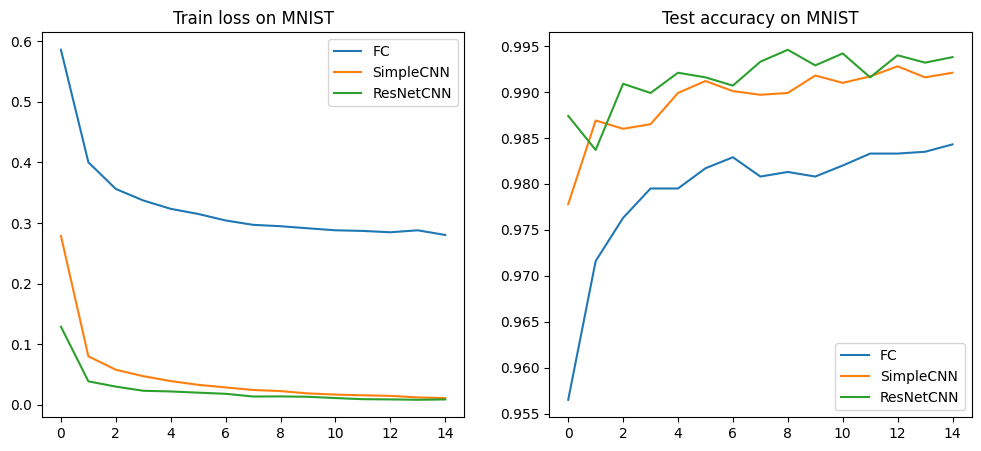

FC: time=107.8s, params=535,818
SimpleCNN: time=132.1s, params=421,642
ResNetCNN: time=206.7s, params=160,906


In [25]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fc_loss, label='FC')
plt.plot(cnn_loss, label='SimpleCNN')
plt.plot(res_loss, label='ResNetCNN')
plt.title("Train loss on MNIST")
plt.legend()

plt.subplot(1,2,2)
plt.plot(fc_acc, label='FC')
plt.plot(cnn_acc, label='SimpleCNN')
plt.plot(res_acc, label='ResNetCNN')
plt.title("Test accuracy on MNIST")
plt.legend()
plt.show()

for name, model, time_ in [
    ("FC", fc_model, fc_time),
    ("SimpleCNN", cnn_model, cnn_time),
    ("ResNetCNN", resnet_model, res_time),
]:
    n_params = sum(p.numel() for p in model.parameters())
    print(f"{name}: time={time_:.1f}s, params={n_params:,}")


### Выводы из графиков для MNIST 
1. Модели показывают примерно одинаковые accuracy > 0.98 . После 3-4 эпохи accuracy перестает стабильно расти
2. Лучшая модель по accuracy и loss RESNETCNN. Она же дольше всех обучается, но имеет меньше всего параметров
   

1.2 Сравнение на CIFAR-10 (20 баллов)
``` python
# Сравните производительность на CIFAR-10:
# - Полносвязная сеть (глубокая)
# - CNN с Residual блоками
# - CNN с регуляризацией и Residual блоками
# 
# Для каждого варианта:
# - Обучите модель с одинаковыми гиперпараметрами
# - Сравните точность и время обучения
# - Проанализируйте переобучение
# - Визуализируйте confusion matrix
# - Исследуйте градиенты (gradient flow)

### Теперь обучим те же модели для Cifar10

In [8]:
print('Training FullyConnectedNet')
fc_model_cifar = FullyConnectedNet(32*32*3, 10)
fc_loss_cifar, fc_acc_cifar, fc_time_cifar = train_and_evaluate(fc_model_cifar, cifar_train_loader, cifar_test_loader, epochs=15)

print('Training SimpleCNN')
cnn_model = SimpleCNN(3, 10)
cnn_loss, cnn_acc, cnn_time = train_and_evaluate(cnn_model, cifar_train_loader, cifar_test_loader, epochs=15)

print('Training CNNResNet')
resnet_model_cifar = CNNResNet(3, 10)
res_loss_cifar, res_acc_cifar, res_time_cifar = train_and_evaluate(resnet_model_cifar, cifar_train_loader, cifar_test_loader, epochs=15)


Training FullyConnectedNet
Epoch 1: train loss=1.8070, test acc=0.4583
Epoch 2: train loss=1.6345, test acc=0.4780
Epoch 3: train loss=1.5496, test acc=0.5038
Epoch 4: train loss=1.4854, test acc=0.5119
Epoch 5: train loss=1.4266, test acc=0.5244
Epoch 6: train loss=1.3799, test acc=0.5303
Epoch 7: train loss=1.3201, test acc=0.5369
Epoch 8: train loss=1.2716, test acc=0.5391
Epoch 9: train loss=1.2170, test acc=0.5347
Epoch 10: train loss=1.1710, test acc=0.5340
Epoch 11: train loss=1.1233, test acc=0.5390
Epoch 12: train loss=1.0805, test acc=0.5421
Epoch 13: train loss=1.0390, test acc=0.5364
Epoch 14: train loss=0.9975, test acc=0.5353
Epoch 15: train loss=0.9579, test acc=0.5321
Training SimpleCNN
Epoch 1: train loss=1.5246, test acc=0.5568
Epoch 2: train loss=1.1963, test acc=0.6310
Epoch 3: train loss=1.0431, test acc=0.6582
Epoch 4: train loss=0.9458, test acc=0.6730
Epoch 5: train loss=0.8731, test acc=0.7065
Epoch 6: train loss=0.8150, test acc=0.7164
Epoch 7: train loss=0.76

### По результам выше видно, что CNN RESNET лучшая модель среди рассматриваемых

In [8]:
class ResidualBlock_2(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_prob)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class CNNWithRegularizedResiduals(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        
        self.res1 = ResidualBlock_2(32, 32, dropout_prob=0.1)
        self.res2 = ResidualBlock_2(32, 64, stride=2, downsample=nn.Sequential(
            nn.Conv2d(32, 64, 1, 2, 0, bias=False),
            nn.BatchNorm2d(64),
        ), dropout_prob=0.4)
        self.res3 = ResidualBlock_2(64, 64, dropout_prob=0.2)
        
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.stem(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.pool(x)
        x = self.fc(x)
        return x


### Для более точного определения RESNET и RESREGNET обучим их на 25 эпохах

In [19]:
print('Training CNNResNet')
resnet_model_cifar = CNNResNet(3, 10)
res_loss_cifar, res_acc_cifar, res_time_cifar = train_and_evaluate(resnet_model_cifar, cifar_train_loader, cifar_test_loader, epochs=25)

Training CNNResNet
Epoch 1: train loss=1.1913, test acc=0.6439
Epoch 2: train loss=0.8012, test acc=0.7101
Epoch 3: train loss=0.6640, test acc=0.7213
Epoch 4: train loss=0.5817, test acc=0.7687
Epoch 5: train loss=0.5130, test acc=0.7970
Epoch 6: train loss=0.4624, test acc=0.7809
Epoch 7: train loss=0.4133, test acc=0.8025
Epoch 8: train loss=0.3706, test acc=0.8096
Epoch 9: train loss=0.3431, test acc=0.8011
Epoch 10: train loss=0.3045, test acc=0.8183
Epoch 11: train loss=0.2731, test acc=0.8102
Epoch 12: train loss=0.2405, test acc=0.8246
Epoch 13: train loss=0.2191, test acc=0.8182
Epoch 14: train loss=0.1902, test acc=0.8244
Epoch 15: train loss=0.1686, test acc=0.8214
Epoch 16: train loss=0.1488, test acc=0.8230
Epoch 17: train loss=0.1284, test acc=0.8279
Epoch 18: train loss=0.1122, test acc=0.8193
Epoch 19: train loss=0.1007, test acc=0.8156
Epoch 20: train loss=0.0904, test acc=0.8071
Epoch 21: train loss=0.0835, test acc=0.8290
Epoch 22: train loss=0.0693, test acc=0.8149


In [20]:
print('Training CNNWithRegularizedResiduals')
resnet_reg_model_cifar = CNNWithRegularizedResiduals(3, 10)
res_reg_loss_cifar, res_reg_acc_cifar, res_reg_time_cifar = train_and_evaluate(resnet_reg_model_cifar, cifar_train_loader, cifar_test_loader, epochs=25)

Training CNNWithRegularizedResiduals
Epoch 1: train loss=1.4107, test acc=0.5968
Epoch 2: train loss=1.0591, test acc=0.6750
Epoch 3: train loss=0.9068, test acc=0.7149
Epoch 4: train loss=0.8064, test acc=0.7397
Epoch 5: train loss=0.7454, test acc=0.7555
Epoch 6: train loss=0.6847, test acc=0.7639
Epoch 7: train loss=0.6411, test acc=0.7841
Epoch 8: train loss=0.6084, test acc=0.7854
Epoch 9: train loss=0.5764, test acc=0.7925
Epoch 10: train loss=0.5429, test acc=0.7926
Epoch 11: train loss=0.5180, test acc=0.8080
Epoch 12: train loss=0.4905, test acc=0.8070
Epoch 13: train loss=0.4675, test acc=0.8127
Epoch 14: train loss=0.4516, test acc=0.8122
Epoch 15: train loss=0.4241, test acc=0.8220
Epoch 16: train loss=0.4107, test acc=0.8245
Epoch 17: train loss=0.3930, test acc=0.8211
Epoch 18: train loss=0.3814, test acc=0.8139
Epoch 19: train loss=0.3700, test acc=0.8291
Epoch 20: train loss=0.3528, test acc=0.8204
Epoch 21: train loss=0.3381, test acc=0.8296
Epoch 22: train loss=0.3252

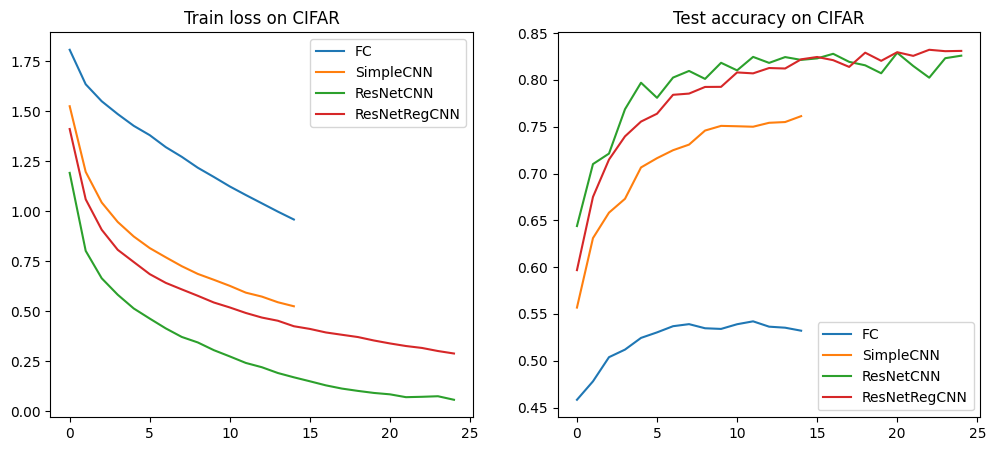

FC: time=218.9s, params=1,707,274
SimpleCNN: time=246.3s, params=422,218
ResNetCNN: time=607.6s, params=161,482
ResNetRegCNN: time=614.9s, params=283,690


In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fc_loss_cifar, label='FC')
plt.plot(cnn_loss, label='SimpleCNN')
plt.plot(res_loss_cifar, label='ResNetCNN')
plt.plot(res_reg_loss_cifar, label='ResNetRegCNN')
plt.title("Train loss on CIFAR")
plt.legend()

plt.subplot(1,2,2)
plt.plot(fc_acc_cifar, label='FC')
plt.plot(cnn_acc, label='SimpleCNN')
plt.plot(res_acc_cifar, label='ResNetCNN')
plt.plot(res_reg_acc_cifar, label='ResNetRegCNN')
plt.title("Test accuracy on CIFAR")
plt.legend()
plt.show()

for name, model, time_ in [
    ("FC", fc_model_cifar, fc_time_cifar),
    ("SimpleCNN", cnn_model, cnn_time),
    ("ResNetCNN", resnet_model_cifar, res_time_cifar),
    ("ResNetRegCNN", resnet_reg_model_cifar, res_reg_time_cifar),
]:
    n_params = sum(p.numel() for p in model.parameters())
    print(f"{name}: time={time_:.1f}s, params={n_params:,}")

### Как видно из графиков accuracy у RESNET с регуляризацией выше всех 0.8322. Немного хуже обычный RESNET (хотя до 15 эпохи он был лучше). При большем количестве эпох RESREGNET скорее всего еще немного увеличит отрыв от RESNET

### Выведем confusion матрицы для каждой модели 

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    device = next(model.parameters()).device
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            # Специально для Fully Connected: сплющиваем вход
            if isinstance(model, FullyConnectedNet):
                xb = xb.view(xb.size(0), -1)
            outputs = model(xb)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



Confusion Matrix for Fully Connected


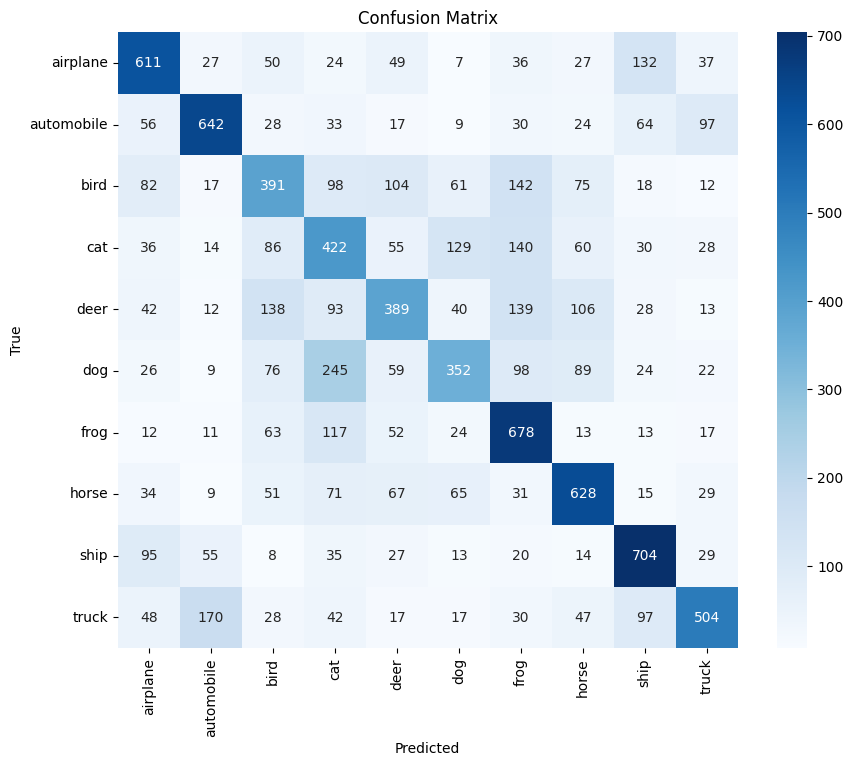

Confusion Matrix for Simple CNN


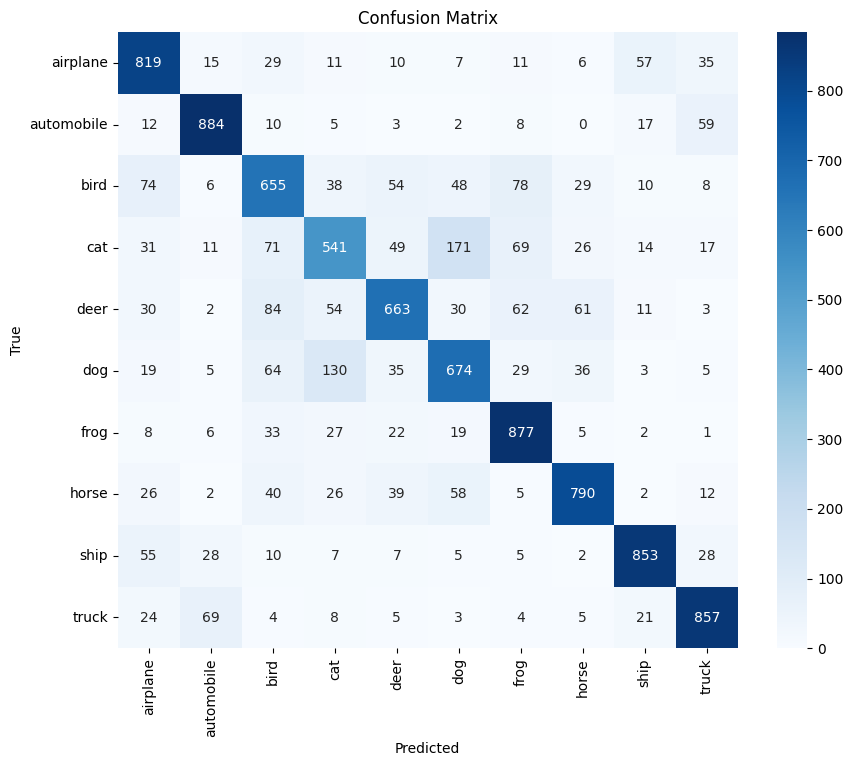

Confusion Matrix for ResNet


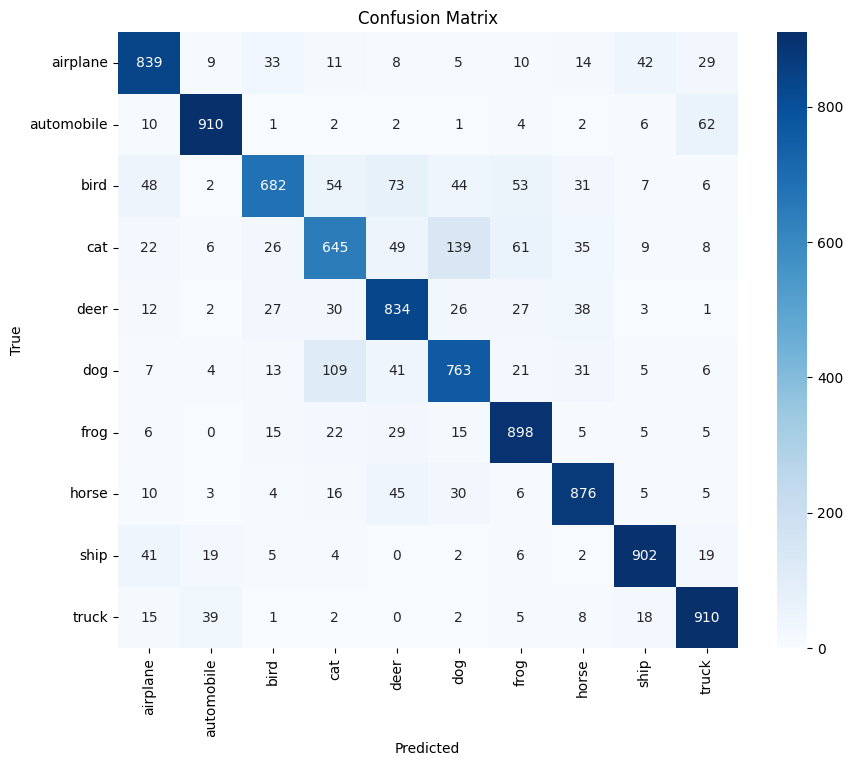

Confusion Matrix for ResNet with Regularization


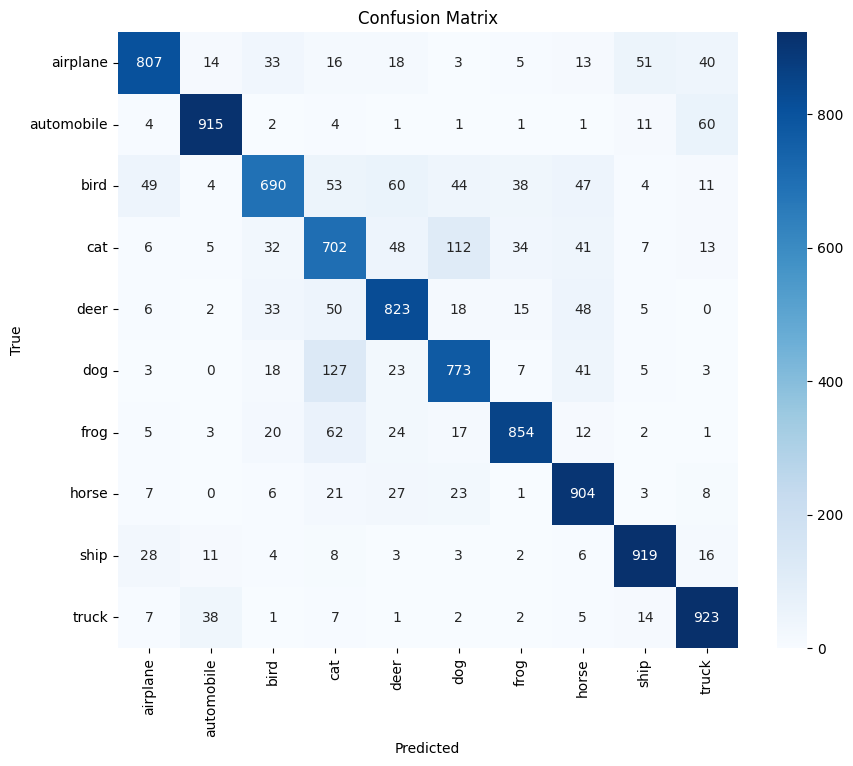

In [29]:
models = [
    fc_model_cifar,
    cnn_model,
    resnet_model_cifar,
    resnet_reg_model_cifar
]

model_names = [
    "Fully Connected",
    "Simple CNN",
    "ResNet",
    "ResNet with Regularization"
]

for model, name in zip(models, model_names):
    print(f"Confusion Matrix for {name}")
    plot_confusion_matrix(
        model,
        cifar_test_loader,
        class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    )


### Confusion матрицы подтверждают предыдущие результаты accuracy 

Задание 2: Анализ архитектур CNN (30 баллов)
Создайте файл homework_cnn_architecture_analysis.py:

2.1 Влияние размера ядра свертки (15 баллов)
```python
# Исследуйте влияние размера ядра свертки:
# - 3x3 ядра
# - 5x5 ядра
# - 7x7 ядра
# - Комбинация разных размеров (1x1 + 3x3)
# 
# Для каждого варианта:
# - Поддерживайте одинаковое количество параметров
# - Сравните точность и время обучения
# - Проанализируйте рецептивные поля
# - Визуализируйте активации первого слоя
```

### Создадим класс для моделей с настраиваемым kernel_size. Буду Тестировать их только на CIFAR.(он посложнее MNIST)

In [10]:
class ResidualBlockKernel(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None, dropout_prob=0.0, use_1x1_3x3=False):
        super().__init__()
        if use_1x1_3x3:
            self.conv1 = nn.Conv2d(in_channels, out_channels, 1, stride, 0, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
        else:
            padding = kernel_size // 2
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)
class CNNWithKernelResiduals(nn.Module):
    def __init__(self,kernel_size, input_channels=3, num_classes=10, use_1x1_3x3=False):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.res1 = ResidualBlockKernel(32, 32, kernel_size=kernel_size, dropout_prob=0.1, use_1x1_3x3=use_1x1_3x3)
        self.res2 = ResidualBlockKernel(32, 64, kernel_size=kernel_size, stride=2, 
                                        downsample=nn.Sequential(
                                            nn.Conv2d(32, 64, 1, 2, 0, bias=False),
                                            nn.BatchNorm2d(64),
                                        ),
                                        dropout_prob=0.4, use_1x1_3x3=use_1x1_3x3)
        self.res3 = ResidualBlockKernel(64, 64, kernel_size=kernel_size, dropout_prob=0.2, use_1x1_3x3=use_1x1_3x3)
        
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.pool(x)
        x = self.fc(x)
        return x


### Обучим модели с kernel размерами 3,5,7 , 1+3 ,  выведем для каждой модели confusion matrix


Training model with kernel 3x3
Epoch 1: train loss=1.3006, test acc=0.5996
Epoch 2: train loss=0.8905, test acc=0.6518
Epoch 3: train loss=0.7577, test acc=0.7361
Epoch 4: train loss=0.6663, test acc=0.7576
Epoch 5: train loss=0.6108, test acc=0.7640
Epoch 6: train loss=0.5552, test acc=0.7843
Epoch 7: train loss=0.5144, test acc=0.7999
Epoch 8: train loss=0.4830, test acc=0.8077
Epoch 9: train loss=0.4468, test acc=0.7992
Epoch 10: train loss=0.4167, test acc=0.8126
Epoch 11: train loss=0.3983, test acc=0.8146
Epoch 12: train loss=0.3697, test acc=0.8222
Epoch 13: train loss=0.3461, test acc=0.8171
Epoch 14: train loss=0.3317, test acc=0.8129
Epoch 15: train loss=0.3155, test acc=0.8277
Kernel 3x3 - Accuracy: 0.8277, Time: 333.9 sec


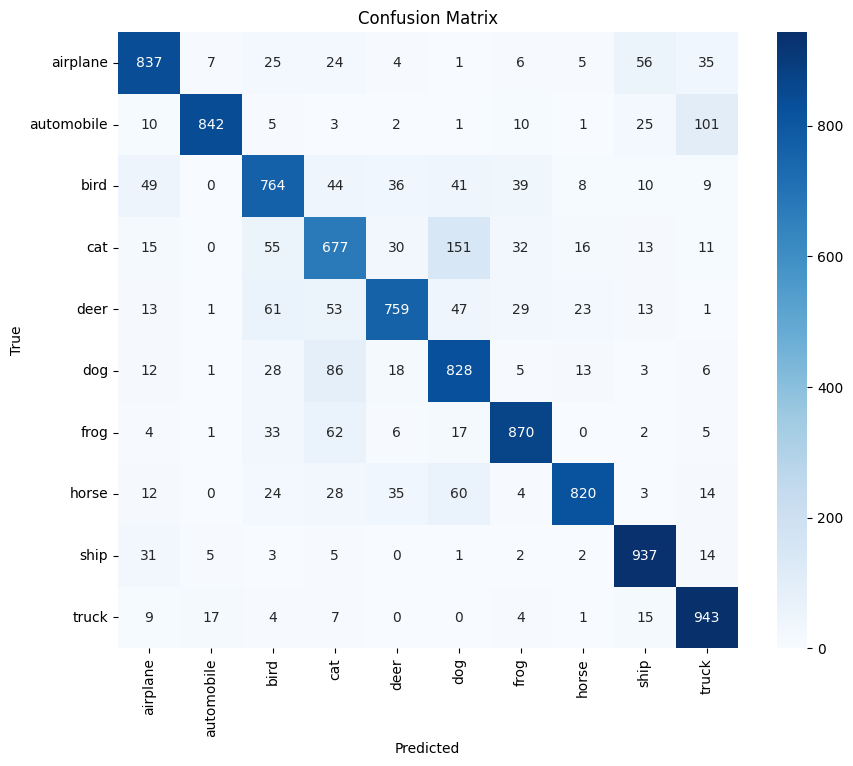


Training model with kernel 5x5
Epoch 1: train loss=1.2765, test acc=0.6490
Epoch 2: train loss=0.8536, test acc=0.7024
Epoch 3: train loss=0.7048, test acc=0.7186
Epoch 4: train loss=0.6146, test acc=0.7724
Epoch 5: train loss=0.5555, test acc=0.7620
Epoch 6: train loss=0.4950, test acc=0.8036
Epoch 7: train loss=0.4502, test acc=0.8027
Epoch 8: train loss=0.4097, test acc=0.8127
Epoch 9: train loss=0.3770, test acc=0.8209
Epoch 10: train loss=0.3470, test acc=0.8233
Epoch 11: train loss=0.3153, test acc=0.8307
Epoch 12: train loss=0.2921, test acc=0.8270
Epoch 13: train loss=0.2709, test acc=0.8291
Epoch 14: train loss=0.2518, test acc=0.8455
Epoch 15: train loss=0.2289, test acc=0.8414
Kernel 5x5 - Accuracy: 0.8455, Time: 398.2 sec


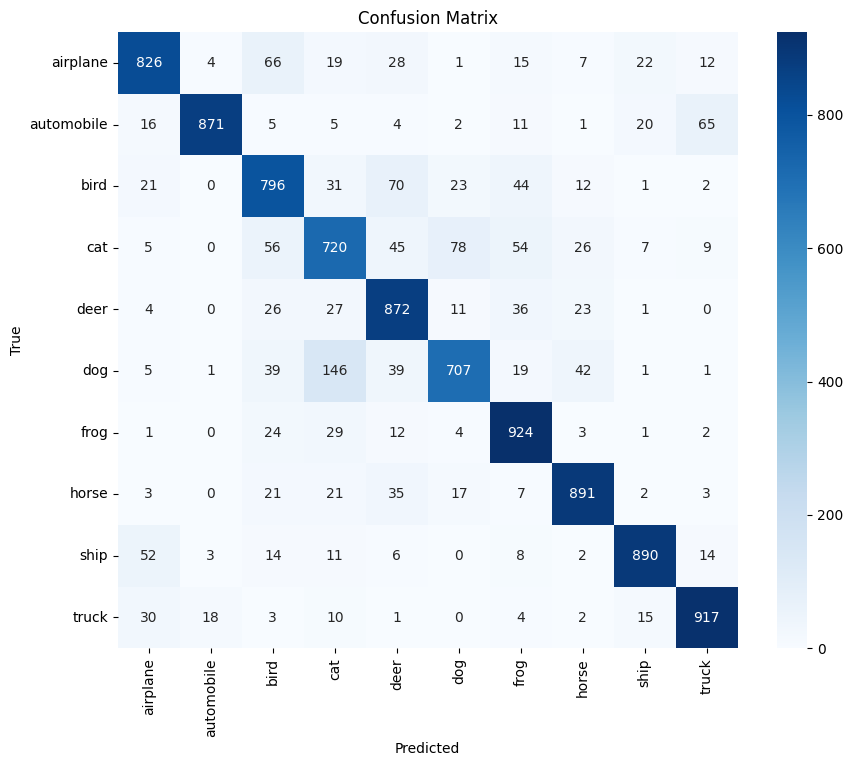


Training model with kernel 7x7
Epoch 1: train loss=1.3292, test acc=0.6280
Epoch 2: train loss=0.9283, test acc=0.6824
Epoch 3: train loss=0.7577, test acc=0.7294
Epoch 4: train loss=0.6491, test acc=0.7679
Epoch 5: train loss=0.5781, test acc=0.7608
Epoch 6: train loss=0.5060, test acc=0.7685
Epoch 7: train loss=0.4587, test acc=0.7851
Epoch 8: train loss=0.4155, test acc=0.8094
Epoch 9: train loss=0.3769, test acc=0.8177
Epoch 10: train loss=0.3374, test acc=0.8126
Epoch 11: train loss=0.3089, test acc=0.8161
Epoch 12: train loss=0.2807, test acc=0.8331
Epoch 13: train loss=0.2603, test acc=0.8275
Epoch 14: train loss=0.2310, test acc=0.8096
Epoch 15: train loss=0.2098, test acc=0.8264
Kernel 7x7 - Accuracy: 0.8331, Time: 554.5 sec


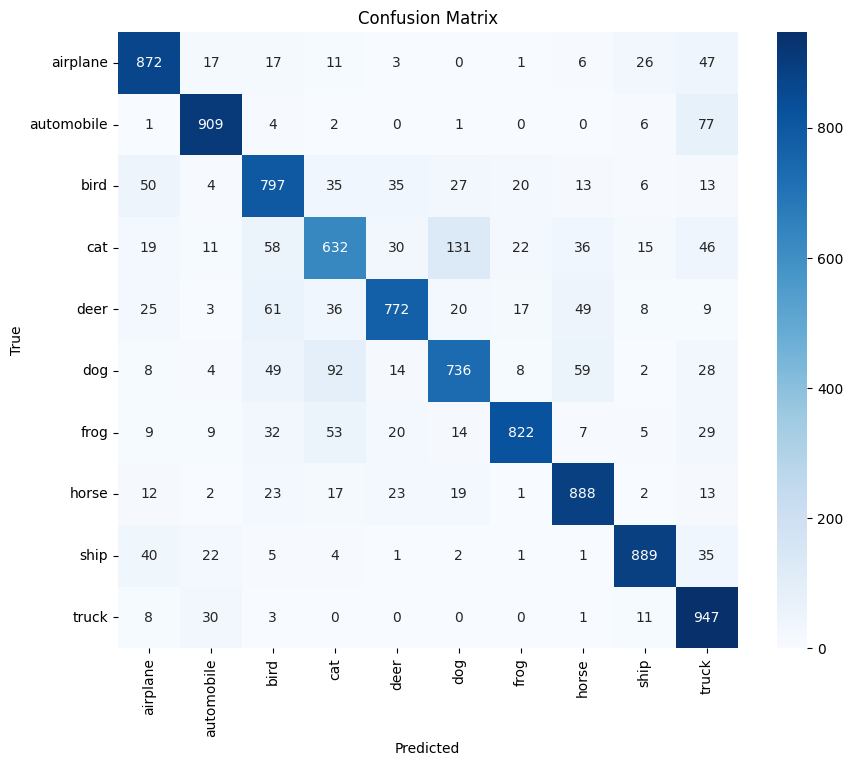


Training model with combination 1x1 + 3x3
Epoch 1: train loss=1.3416, test acc=0.6164
Epoch 2: train loss=0.9744, test acc=0.6790
Epoch 3: train loss=0.8383, test acc=0.7168
Epoch 4: train loss=0.7593, test acc=0.7345
Epoch 5: train loss=0.6969, test acc=0.7515
Epoch 6: train loss=0.6489, test acc=0.7719
Epoch 7: train loss=0.6142, test acc=0.7651
Epoch 8: train loss=0.5761, test acc=0.7803
Epoch 9: train loss=0.5527, test acc=0.7754
Epoch 10: train loss=0.5208, test acc=0.7829
Epoch 11: train loss=0.4971, test acc=0.7899
Epoch 12: train loss=0.4784, test acc=0.7946
Epoch 13: train loss=0.4545, test acc=0.7954
Epoch 14: train loss=0.4369, test acc=0.7857
Epoch 15: train loss=0.4246, test acc=0.8016
1x1+3x3 - Accuracy: 0.8016, Time: 286.4 sec


TypeError: plot_confusion_matrix() got an unexpected keyword argument 'title'

In [14]:
loss_kernels = []
acc_kernels = []
time_kernels = []
kernel_labels = ['3x3', '5x5', '7x7']

for kernel_size in [3, 5, 7]:
    print(f"\nTraining model with kernel {kernel_size}x{kernel_size}")
    model = CNNWithKernelResiduals(kernel_size=kernel_size).to(device)
    start_time = time.time()
    loss, acc, _ = train_and_evaluate(model, cifar_train_loader, cifar_test_loader, epochs=15)
    duration = time.time() - start_time
    
    loss_kernels.append(loss)
    acc_kernels.append(acc)
    time_kernels.append(duration)
    
    print(f"Kernel {kernel_size}x{kernel_size} - Accuracy: {max(acc):.4f}, Time: {duration:.1f} sec")
    
    plot_confusion_matrix(
        model,
        cifar_test_loader,
        class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'],
    )

# Комбинация 1x1+3x3
print("\nTraining model with combination 1x1 + 3x3")
model = CNNWithKernelResiduals(use_1x1_3x3=True,kernel_size=3).to(device)
start_time = time.time()
loss, acc, _ = train_and_evaluate(model, cifar_train_loader, cifar_test_loader, epochs=15)
duration = time.time() - start_time

loss_kernels.append(loss)
acc_kernels.append(acc)
time_kernels.append(duration)
kernel_labels.append('1x1+3x3')

print(f"1x1+3x3 - Accuracy: {acc[-1]:.4f}, Time: {duration:.1f} sec")

plot_confusion_matrix(
    model,
    cifar_test_loader,
    class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'],
)


### Была ошибка в вызове функции, ниже вызвал правильно(чтобы не запускать все обучение еще раз)

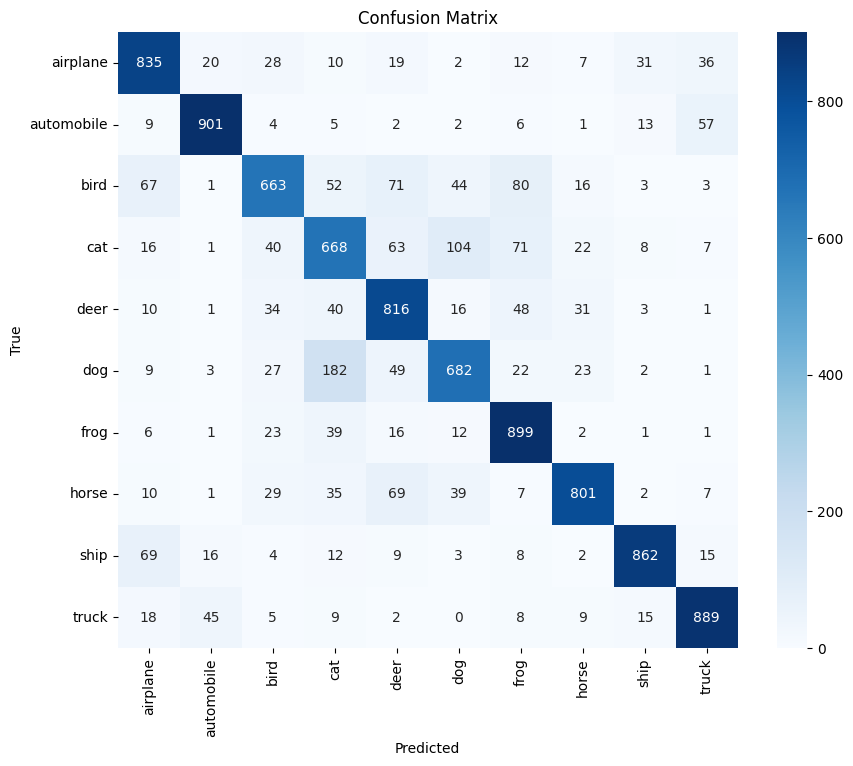

In [15]:
plot_confusion_matrix(
    model,
    cifar_test_loader,
    class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'],
)

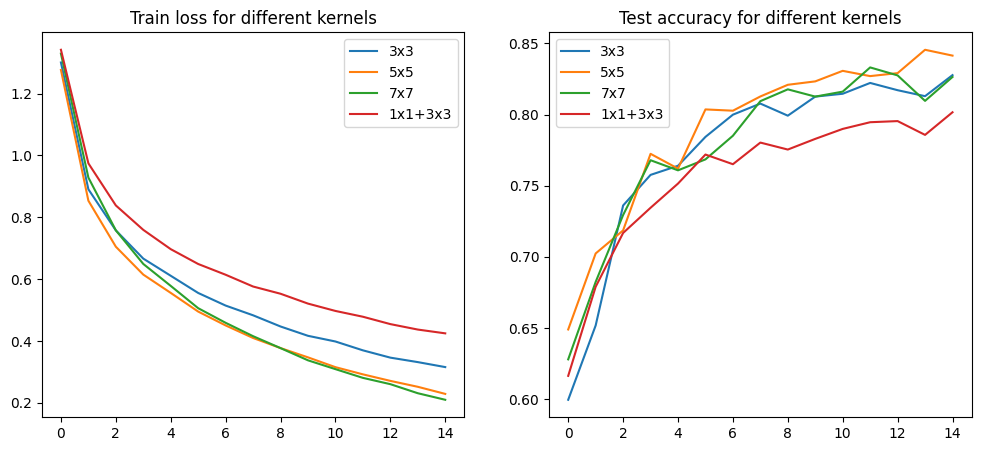

3x3: Time=333.9s
5x5: Time=398.2s
7x7: Time=554.5s
1x1+3x3: Time=286.4s


In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for loss, label in zip(loss_kernels, kernel_labels):
    plt.plot(loss, label=label)
plt.title("Train loss for different kernels")
plt.legend()

plt.subplot(1, 2, 2)
for acc, label in zip(acc_kernels, kernel_labels):
    plt.plot(acc, label=label)
plt.title("Test accuracy for different kernels")
plt.legend()

plt.show()

for label, time_ in zip(kernel_labels, time_kernels):
    print(f"{label}: Time={time_:.1f}s")


### Из графиков видно, что лучшая модель с kernel_size 5x5 с accuracy 0.8455

### Визуализируем активации первого слоя

In [21]:
def visualize_first_layer_activations(model, test_loader, num_images=3):
    model.eval()
    device = next(model.parameters()).device
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    images = images.to(device)

    first_conv = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            first_conv = module
            break
    if first_conv is None:
        raise ValueError("В модели не найден сверточный слой для визуализации.")

    with torch.no_grad():
        activations = first_conv(images[:num_images])
    activations = activations.cpu()

    for idx in range(num_images):
        plt.figure(figsize=(12, 2))
        for i in range(min(8, activations.shape[1])):  
            plt.subplot(1, 8, i+1)
            plt.imshow(activations[idx, i].numpy(), cmap='viridis')
            plt.axis('off')
        plt.suptitle(f'Активации для изображения {idx}')
        plt.show()



Визуализация активаций для модели с комбинацией 1x1+3x3:


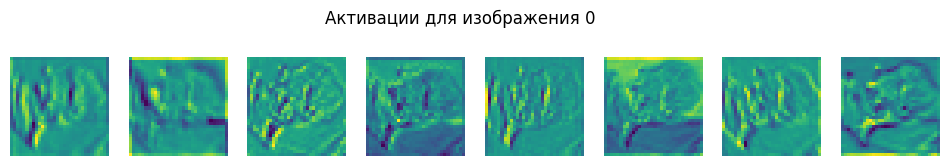

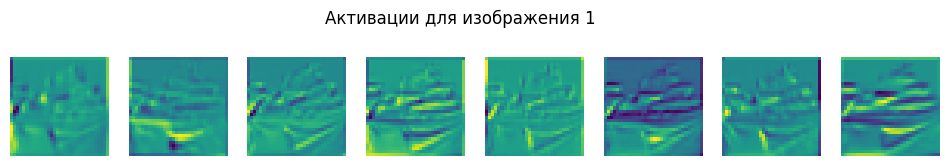

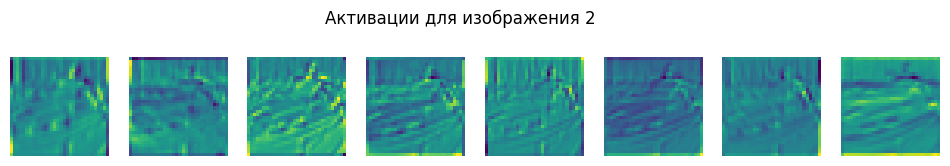

In [22]:

print("Визуализация активаций для модели с комбинацией 1x1+3x3:")
visualize_first_layer_activations(model, cifar_test_loader)


### Вот так модель выделяет зоны на изображении

2.2 Влияние глубины CNN (15 баллов)
``` python 
# Исследуйте влияние глубины CNN:
# - Неглубокая CNN (2 conv слоя)
# - Средняя CNN (4 conv слоя)
# - Глубокая CNN (6+ conv слоев)
# - CNN с Residual связями
# 
# Для каждого варианта:
# - Сравните точность и время обучения
# - Проанализируйте vanishing/exploding gradients
# - Исследуйте эффективность Residual связей
# - Визуализируйте feature maps

### Создам классы для каждой модели 

In [11]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [12]:
class MediumCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(),   
            nn.Conv2d(128, 128, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [13]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),   
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(),  
            nn.Conv2d(128, 128, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [14]:
class DeepResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(),
        )
        self.res1 = ResidualBlock_2(32, 32)
        self.res2 = ResidualBlock_2(32, 64, stride=2, downsample=nn.Sequential(
            nn.Conv2d(32, 64, 1, 2, 0), nn.BatchNorm2d(64)))
        self.res3 = ResidualBlock_2(64, 64)
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [15]:

small_cnn = SmallCNN(num_classes=10).to(device)
medium_cnn = MediumCNN(num_classes=10).to(device)
deep_cnn = DeepCNN(num_classes=10).to(device)
deep_resnet = DeepResNet(num_classes=10).to(device)
models = [
    ("SmallCNN", small_cnn),
    ("MediumCNN", medium_cnn),
    ("DeepCNN", deep_cnn),
    ("DeepResNet", deep_resnet),
]

results = []

for name, model in models:
    print(f"\nTraining {name}")
    start_time = time.time()
    loss, acc, _ = train_and_evaluate(model,cifar_train_loader, cifar_test_loader, epochs=15)
    duration = time.time() - start_time
    print(f"Model: {name} | Accuracy: {max(acc):.4f} | Time: {duration:.1f}s")
    results.append((name, max(acc), duration))



Training SmallCNN
Epoch 1: train loss=1.6753, test acc=0.4722
Epoch 2: train loss=1.3768, test acc=0.5356
Epoch 3: train loss=1.2712, test acc=0.5649
Epoch 4: train loss=1.2016, test acc=0.5818
Epoch 5: train loss=1.1311, test acc=0.5927
Epoch 6: train loss=1.0728, test acc=0.6219
Epoch 7: train loss=1.0308, test acc=0.6339
Epoch 8: train loss=0.9978, test acc=0.6263
Epoch 9: train loss=0.9707, test acc=0.6492
Epoch 10: train loss=0.9498, test acc=0.6618
Epoch 11: train loss=0.9282, test acc=0.6698
Epoch 12: train loss=0.9116, test acc=0.6659
Epoch 13: train loss=0.8979, test acc=0.6780
Epoch 14: train loss=0.8838, test acc=0.6740
Epoch 15: train loss=0.8693, test acc=0.6785
Model: SmallCNN | Accuracy: 0.6785 | Time: 261.4s

Training MediumCNN
Epoch 1: train loss=1.5734, test acc=0.5418
Epoch 2: train loss=1.1869, test acc=0.6045
Epoch 3: train loss=0.9926, test acc=0.6719
Epoch 4: train loss=0.8624, test acc=0.6876
Epoch 5: train loss=0.7746, test acc=0.7237
Epoch 6: train loss=0.712

### Самый лучший результат среди этих модлей показал DeepRESNET, доказывая эффективность residual слоев.

In [17]:
def register_gradient_hooks(model, name="Model"):
    grad_info = {}

    def save_grad(name):
        def hook(grad):
            grad_info[name] = grad.detach().abs().mean().item()
        return hook

    for n, p in model.named_parameters():
        if p.requires_grad:
            p.register_hook(save_grad(n))
    
    return grad_info



In [18]:
criterion = nn.CrossEntropyLoss()

for model_name, model in models:
    print(f"\nAnalyzing gradients for {model_name}")
    model.to(device)
    model.train()
    
    grad_info = register_gradient_hooks(model, model_name)
    
    images, labels = next(iter(cifar_train_loader))
    images, labels = images.to(device), labels.to(device)
    
    optimizer = optim.Adam(model.parameters())  # добавляем оптимизатор, чтобы не было ошибки
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    
    for layer_name, grad_val in grad_info.items():
        print(f"{layer_name}: mean |grad| = {grad_val:.2e}")


Analyzing gradients for SmallCNN
classifier.1.bias: mean |grad| = 1.65e-02
classifier.1.weight: mean |grad| = 8.57e-03
features.2.weight: mean |grad| = 3.31e-03
features.2.bias: mean |grad| = 1.63e-02
features.0.weight: mean |grad| = 2.56e-02
features.0.bias: mean |grad| = 1.02e-01

Analyzing gradients for MediumCNN
classifier.1.bias: mean |grad| = 9.23e-03
classifier.1.weight: mean |grad| = 4.22e-03
features.6.weight: mean |grad| = 7.20e-04
features.6.bias: mean |grad| = 1.70e-03
features.4.weight: mean |grad| = 7.23e-04
features.4.bias: mean |grad| = 4.57e-03
features.2.weight: mean |grad| = 3.11e-03
features.2.bias: mean |grad| = 2.59e-02
features.0.weight: mean |grad| = 2.74e-02
features.0.bias: mean |grad| = 9.94e-02

Analyzing gradients for DeepCNN
classifier.1.bias: mean |grad| = 1.13e-02
classifier.1.weight: mean |grad| = 4.33e-03
features.10.weight: mean |grad| = 1.11e-03
features.10.bias: mean |grad| = 1.64e-03
features.8.weight: mean |grad| = 1.04e-03
features.8.bias: mean 

### Не вижу явных vanishing/exploding gradients

In [20]:
def get_first_conv_layer(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            return module, name
    return None, None

def visualize_feature_maps(model, test_loader, num_images=3, max_channels=8):
    model.eval()
    device = next(model.parameters()).device
    images, _ = next(iter(test_loader))
    images = images.to(device)

    conv_layer, layer_name = get_first_conv_layer(model)
    if conv_layer is None:
        print("Conv2d layer not found in model!")
        return

    activations = []

    def hook_fn(module, input, output):
        activations.append(output.cpu())

    hook = conv_layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        _ = model(images[:num_images])

    hook.remove()

    feature_maps = activations[0]

    for img_idx in range(num_images):
        plt.figure(figsize=(12, 2))
        for ch in range(min(max_channels, feature_maps.shape[1])):
            plt.subplot(1, max_channels, ch+1)
            plt.imshow(feature_maps[img_idx, ch], cmap='viridis')
            plt.axis('off')
        plt.suptitle(f'Feature maps from layer {layer_name} for image {img_idx}')
        plt.show()


Visualizing feature maps for SmallCNN


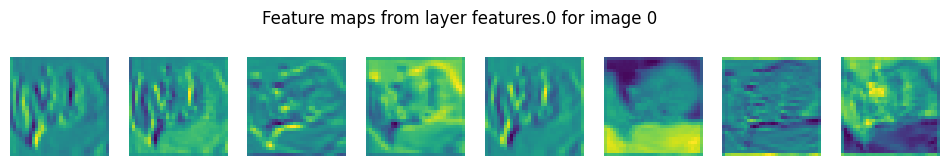

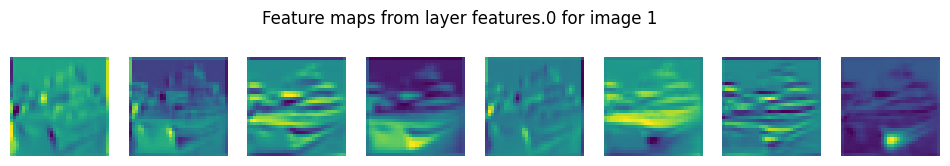

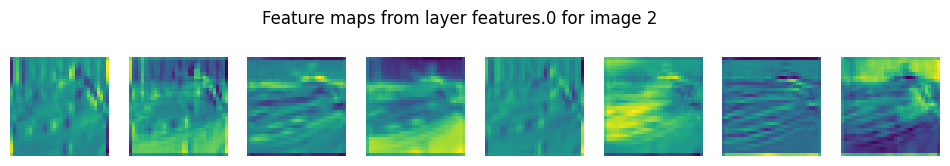

Visualizing feature maps for MediumCNN


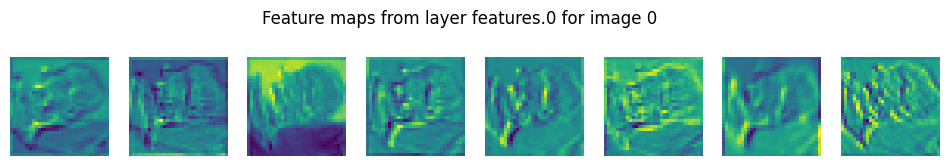

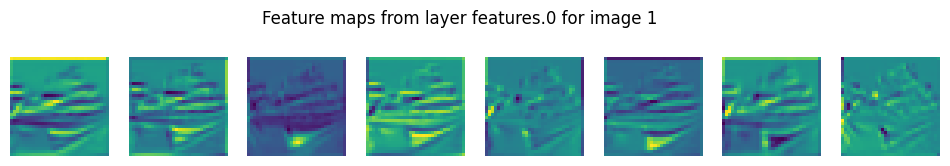

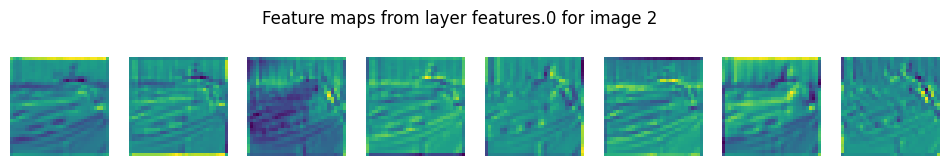

Visualizing feature maps for DeepCNN


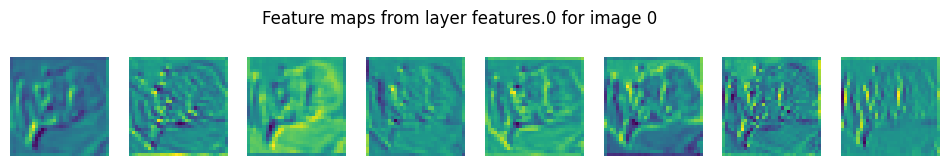

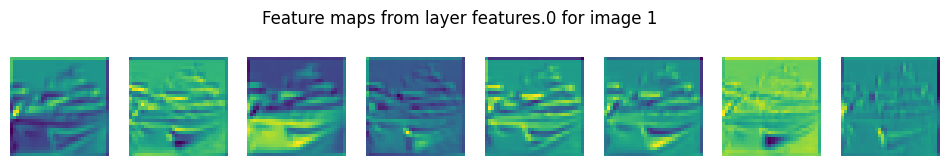

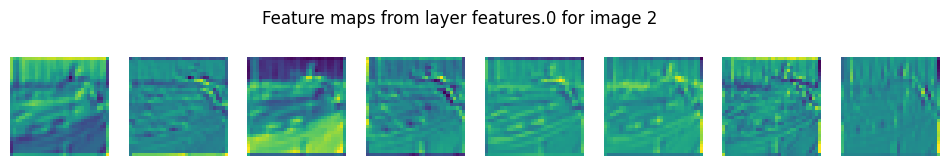

Visualizing feature maps for DeepResNet


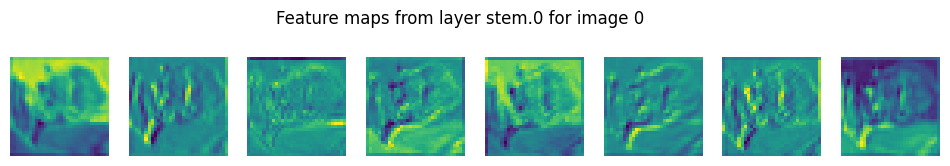

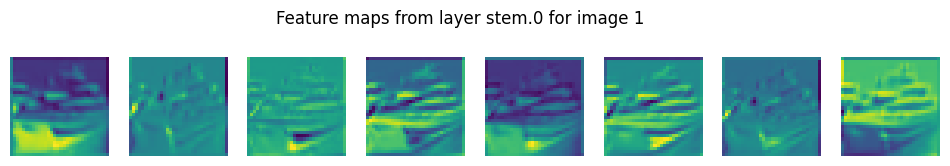

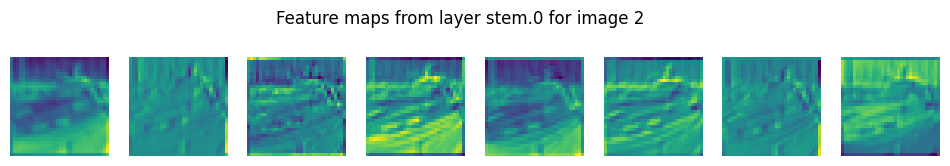

In [21]:
for name, model in models:
    print(f"Visualizing feature maps for {name}")
    visualize_feature_maps(model, cifar_test_loader)

### Как можно увидеть модели выделяют схожие участки на картинках

3.1 Реализация кастомных слоев (15 баллов)
```python
# Реализуйте кастомные слои:
# - Кастомный сверточный слой с дополнительной логикой
# - Attention механизм для CNN
# - Кастомная функция активации
# - Кастомный pooling слой
# 
# Для каждого слоя:
# - Реализуйте forward и backward проходы
# - Добавьте параметры если необходимо
# - Протестируйте на простых примерах
# - Сравните с стандартными аналогами

### Кастомный сверточный слой (масштабирование результата свертки)

In [23]:
class CustomConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, custom_param=1.0):
        super().__init__()
        self.custom_param = custom_param
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=True)

    def forward(self, x):
        conv_output = self.conv(x)
        output_with_logic = conv_output * self.custom_param
        return output_with_logic

class SimpleCNNWithCustomConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.custom_conv = CustomConv2D(in_channels=3, out_channels=16, kernel_size=3, padding=1, custom_param=1.5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.custom_conv(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Attention механизм для CNN "Squeeze-and-Excitation Networks" (Hu et al., 2018)

In [38]:
class SqueezeAndExcitation(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SimpleCNNWithSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.se1 = SqueezeAndExcitation(channels=16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.se2 = SqueezeAndExcitation(channels=32)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.se1(self.relu1(self.conv1(x))))
        x = self.pool2(self.se2(self.relu2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.relu2(self.fc1(x))
        x = self.fc2(x)
        return x

### Кастомная функция активации. Гибрид Swish и Leaky Relu

In [29]:
class CustomLeakySwish(nn.Module):
    def __init__(self, alpha=0.01):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return x * torch.sigmoid(x) + self.alpha * F.relu(x)
class SimpleCNNWithCustomActivation(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.custom_activation1 = CustomLeakySwish(alpha=0.02)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.custom_activation2 = CustomLeakySwish(alpha=0.02)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.custom_activation1(self.conv1(x)))
        x = self.pool2(self.custom_activation2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.custom_activation2(self.fc1(x))
        x = self.fc2(x)
        return x

### Кастомный pooling слой

In [30]:
class LpPool2DFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, kernel_size, stride, p):
        ctx.kernel_size = kernel_size
        ctx.stride = stride
        ctx.p = p

        output = F.unfold(input, kernel_size=kernel_size, stride=stride)
        output = output.view(input.size(0), input.size(1), kernel_size*kernel_size, -1)

        abs_output_pow_p = torch.pow(torch.abs(output) + 1e-8, p)
        sum_abs_output_pow_p = torch.sum(abs_output_pow_p, dim=2)

        lp_norm_output = torch.where(sum_abs_output_pow_p > 1e-12,
                                     torch.pow(sum_abs_output_pow_p, 1.0 / p),
                                     torch.zeros_like(sum_abs_output_pow_p))

        out_height = (input.size(2) - kernel_size) // stride + 1
        out_width = (input.size(3) - kernel_size) // stride + 1
        output_final = lp_norm_output.view(input.size(0), input.size(1), out_height, out_width)

        ctx.save_for_backward(input, output_final)

        return output_final

    @staticmethod
    def backward(ctx, grad_output):
        input, output_final = ctx.saved_tensors
        kernel_size = ctx.kernel_size
        stride = ctx.stride
        p = ctx.p

        grad_input = torch.zeros_like(input)

        grad_output_unfolded = grad_output.view(grad_output.size(0), grad_output.size(1), -1)
        input_unfolded = F.unfold(input, kernel_size=kernel_size, stride=stride)
        input_unfolded_view = input_unfolded.view(input.size(0), input.size(1), kernel_size * kernel_size, -1)
        lp_norm_output_expanded = output_final.view(input.size(0), input.size(1), 1, -1).expand_as(input_unfolded_view)

        if p == 1:
            grad_local_unfolded = torch.sign(input_unfolded_view)
        elif p == 2:
            grad_local_unfolded = input_unfolded_view / (lp_norm_output_expanded + 1e-8)
        else:
            abs_input_unfolded_pow_p_minus_2 = torch.where(input_unfolded_view != 0,
                                                           torch.pow(torch.abs(input_unfolded_view), p - 2),
                                                           torch.zeros_like(input_unfolded_view))
            numerator = input_unfolded_view * abs_input_unfolded_pow_p_minus_2
            denominator = torch.pow(lp_norm_output_expanded + 1e-8, p - 1)
            grad_local_unfolded = numerator / denominator

        grad_output_expanded = grad_output_unfolded.unsqueeze(2).expand_as(input_unfolded_view)
        grad_unfolded = grad_local_unfolded * grad_output_expanded

        grad_input = F.fold(grad_unfolded.view(grad_unfolded.size(0), -1, grad_unfolded.size(3)),
                             output_size=(input.size(2), input.size(3)),
                             kernel_size=kernel_size,
                             stride=stride)

        return grad_input, None, None, None

class CustomLpPooling2D(nn.Module):
    def __init__(self, kernel_size, stride=None, p=2):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.p = p

    def forward(self, x):
        return LpPool2DFunction.apply(x, self.kernel_size, self.stride, self.p)

class SimpleCNNWithLpPooling(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.lp_pool1 = CustomLpPooling2D(kernel_size=2, stride=2, p=2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.lp_pool2 = CustomLpPooling2D(kernel_size=2, stride=2, p=2)

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.lp_pool1(self.relu1(self.conv1(x)))
        x = self.lp_pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

In [48]:
custom_conv_model = SimpleCNNWithCustomConv().to(device)
se_model = SimpleCNNWithSE().to(device)
custom_activation_model = SimpleCNNWithCustomActivation().to(device)
lp_pooling_model = SimpleCNNWithLpPooling().to(device) 

models_to_evaluate = [
    ("CustomConvCNN", custom_conv_model),
    ("SE_CNN", se_model),
    ("CustomActivationCNN", custom_activation_model),
    ("LpPoolingCNN", lp_pooling_model),
]


for name, model in models_to_evaluate:
    print(f"\nTraining {name}")
    losses,acc,duration = train_and_evaluate(model, cifar_train_loader, test_loader_sub, epochs=10)
    print(f"Model: {name} | Best Accuracy: {max(acc):.4f} | Time: {duration:.1f}s")


Training CustomConvCNN
Epoch 1: train loss=1.4687, test acc=0.5710
Epoch 2: train loss=1.1298, test acc=0.6000
Epoch 3: train loss=0.9936, test acc=0.6380
Epoch 4: train loss=0.8968, test acc=0.6720
Epoch 5: train loss=0.8216, test acc=0.6760
Epoch 6: train loss=0.7582, test acc=0.7010
Epoch 7: train loss=0.6946, test acc=0.7030
Epoch 8: train loss=0.6377, test acc=0.6900
Epoch 9: train loss=0.5861, test acc=0.7000
Epoch 10: train loss=0.5290, test acc=0.7170
Model: CustomConvCNN | Best Accuracy: 0.7170 | Time: 133.8s

Training SE_CNN
Epoch 1: train loss=1.6289, test acc=0.5130
Epoch 2: train loss=1.3017, test acc=0.5650
Epoch 3: train loss=1.1711, test acc=0.5820
Epoch 4: train loss=1.0713, test acc=0.6290
Epoch 5: train loss=0.9927, test acc=0.6530
Epoch 6: train loss=0.9308, test acc=0.6490
Epoch 7: train loss=0.8718, test acc=0.6750
Epoch 8: train loss=0.8220, test acc=0.6850
Epoch 9: train loss=0.7808, test acc=0.6860
Epoch 10: train loss=0.7362, test acc=0.6860
Model: SE_CNN | B

### Результаты оказались довольно низкими(но и использовалась простая модель как база), но придумать хорошие кастомные слои сложно и нужно много времени на подбор параметров для кастомных слоев
### А теперь сравним результаты с такой же простой моделью (ниже) без кастомных слоев

In [43]:
class StandardCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu_fc(self.fc1(x))
        x = self.fc2(x)
        return x

In [47]:
name = 'StandardCNN'
model = StandardCNN().to(device) 
print(f"\nTraining {name}")
losses,acc,duration = train_and_evaluate(model, cifar_train_loader, cifar_test_loader, epochs=10)
print(f"Model: {name} | Best Accuracy: {max(acc):.4f} | Time: {duration:.1f}s")


Training StandardCNN
Epoch 1: train loss=1.5490, test acc=0.5371
Epoch 2: train loss=1.2074, test acc=0.5933
Epoch 3: train loss=1.0544, test acc=0.6315
Epoch 4: train loss=0.9428, test acc=0.6719
Epoch 5: train loss=0.8607, test acc=0.6688
Epoch 6: train loss=0.7973, test acc=0.6818
Epoch 7: train loss=0.7431, test acc=0.6855
Epoch 8: train loss=0.6930, test acc=0.6984
Epoch 9: train loss=0.6474, test acc=0.6962
Epoch 10: train loss=0.6033, test acc=0.6921
Model: StandardCNN | Best Accuracy: 0.6984 | Time: 146.8s


### Оказалось, что все кастомные слои кроме модели с Attention механизмом для CNN "Squeeze-and-Excitation Networks" немного лучше, чем стандартная модель. Разница незначительная и скорее всего не является доказательством что эти модели лучше, чем стандартная, а вызвана рандомным выбором весов в начале обучения. Как я уже писал выше придумать хорошие кастомные слои сложно и нужно много времени на подбор параметров для кастомных слоев.

3.2 Эксперименты с Residual блоками (15 баллов)¶
```python
# Исследуйте различные варианты Residual блоков:
# - Базовый Residual блок
# - Bottleneck Residual блок
# - Wide Residual блок
# 
# Для каждого варианта:
# - Реализуйте блок с нуля
# - Сравните производительность
# - Проанализируйте количество параметров
# - Исследуйте стабильность обучения

### Создадим Residual классы  и классы моделей для Bottleneck и WideResidual. Используем базовый Residual блок из кода выше 

In [69]:
class BottleneckResidualBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion),
        )
        self.shortcut = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.shortcut is not None:
            identity = self.shortcut(x)

        out += identity
        return self.relu(out)

In [70]:
class BottleneckCNN(nn.Module):
    def __init__(self, num_blocks=[3, 4, 6, 3], num_classes=10, base_channels=64):
        super().__init__()
        self.in_channels = base_channels
        self.conv1 = nn.Conv2d(3, base_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(BottleneckResidualBlock, base_channels, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(BottleneckResidualBlock, base_channels * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(BottleneckResidualBlock, base_channels * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(BottleneckResidualBlock, base_channels * 8, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_channels * 8 * BottleneckResidualBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [56]:
class WideResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.shortcut = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.shortcut is not None:
            identity = self.shortcut(x)

        out += identity
        return self.relu(out)

In [57]:
class WideCNN(nn.Module):
    def __init__(self, depth, width_factor=2, dropout_rate=0.0, num_classes=10):
        super().__init__()
        assert (depth - 4) % 6 == 0, 'Wide-ResNet depth should be 6n+4'
        n = (depth - 4) // 6

        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(WideResidualBlock, 16 * width_factor, n, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(WideResidualBlock, 32 * width_factor, n, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(WideResidualBlock, 64 * width_factor, n, stride=2, dropout_rate=dropout_rate)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * width_factor * WideResidualBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout_rate):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_rate))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, stride=1, dropout_rate=dropout_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### Используем 8 эпох (потому что эти модели обучаются дольше) 

In [72]:
bottleneck_model = BottleneckCNN(num_blocks=[2,1,2,1], num_classes=10).to(device)
wide_model_16_4 = WideCNN(depth=16, width_factor=4, dropout_rate=0.2, num_classes=10).to(device)
res_net_model = CNNWithRegularizedResiduals().to(device)
models_to_evaluate = [
    ("CNNWithRegularizedResidualst", res_net_model),
    ("BottleneckCNN", bottleneck_model),
    ("WideCNN_16_4", wide_model_16_4),
]

epochs = 8

for name, model in models_to_evaluate:
    print(f"\nTraining {name}")
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Model Parameters: {num_params:,}")
    losses, acc, duration = train_and_evaluate(model, cifar_train_loader, test_loader_sub, epochs=epochs)
    print(f"Model: {name} | Best Accuracy: {max(acc):.4f} | Time: {duration:.1f}s")


Training CNNWithRegularizedResidualst
  Model Parameters: 283,690
Epoch 1: train loss=1.4282, test acc=0.5820
Epoch 2: train loss=1.0690, test acc=0.6880
Epoch 3: train loss=0.9278, test acc=0.7170
Epoch 4: train loss=0.8323, test acc=0.7290
Epoch 5: train loss=0.7682, test acc=0.7550
Epoch 6: train loss=0.7228, test acc=0.7630
Epoch 7: train loss=0.6781, test acc=0.7790
Epoch 8: train loss=0.6392, test acc=0.8060
Model: CNNWithRegularizedResidualst | Best Accuracy: 0.8060 | Time: 182.1s

Training BottleneckCNN
  Model Parameters: 9,216,330
Epoch 1: train loss=1.2958, test acc=0.6030
Epoch 2: train loss=0.8754, test acc=0.7040
Epoch 3: train loss=0.6966, test acc=0.7350
Epoch 4: train loss=0.5702, test acc=0.7840
Epoch 5: train loss=0.4699, test acc=0.7660
Epoch 6: train loss=0.3791, test acc=0.8200
Epoch 7: train loss=0.3092, test acc=0.7700
Epoch 8: train loss=0.2422, test acc=0.8020
Model: BottleneckCNN | Best Accuracy: 0.8200 | Time: 814.6s

Training WideCNN_16_4
  Model Parameter

### Среди этих моделей самой лучшей оказалась WideCNN с глубиной 16 и шириной 4 с accuracy = 0.85, BottleneckCNN  дольше всех обучается и имеет больше параметров. BottleNeck обучается нестабильно ( accuracy прыгает) 